# Competition: Modulation format classification

Enter your team name here:

In [6]:
# Bevore you start, please enter your team name!
team_name = 'REFERENCE_IQ_POWER_F1.3'

The main code starts here...

In [7]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pickle

Helper code that computes the the classification error rate, i.e. $\hat{P}(\hat{\mathsf{y}} \neq \mathsf{y})$, an estimate of the error probability. The classification is obtained from $N$ pairs $(\boldsymbol{x}_i, y_i)$, $i=1,\ldots, N$ and the corresponding estimates $\hat{y}_i = f(\boldsymbol{x}_i)$ as follows
$$
\hat{P}(\hat{\mathsf{y}} \neq \mathsf{y}) = \frac{1}{N}\sum_{i=1}^N \mathbb{1}_{\{f(\boldsymbol{x}_i) \neq y_i\}}
$$
where $\mathbb{1}_{\{E\}}$ is the indicator function, which returns 1 if the event $E$ is true and 0 otherwise

In [8]:
# helper function to compute the classification error rate.
def CER(predictions, labels):
    """Calculates the classification error rate."""
    return (np.sum(predictions != labels) / len(predictions))

This is a helper function that double-checks if the data is correct and carries out some sanity-checks.

In [9]:
# Checks if the data you upload has the correct type/form
def check_predictions(test_data, predictions, valid_values):
    """Chcecks if predicitions has the right length and type."""
    if isinstance(predictions,np.ndarray):
        print('type ok.')
    else:
        raise Exception('wrong type, predictions should be of type np.ndarray')
    if predictions.ndim != 1:
        raise Exception('wrong dimension, predictions must have dim 1')
    else:
        print('dim ok.')
    if len(test_data) != len(predictions):
        raise Exception('wrong length, "X_test" and "predictions" must have the same length.')
    else:
        print('length ok.')
    all_values_valid = True
    for i in range(len(predictions)):
        if (predictions[i] not in valid_values):
            print('All values of "predictions" have to be in "valid data".')
            all_values_valid = False
            break
    if all_values_valid:
        print('Predictions are valid values.')

## Task 1: Distinguish between BPSK and QPSK
You are given samples of an unknown modulation format and your task is to determine the modulation format in order to setup the receiver correctly. 

Show the classification error for the validation set for each SNR point separately.

Load datasets. They are stored as a pickle file.

The dataset contains traces of 128 complex samples (Inphase and Quadrature component) of received signals with different modulation formats and at different signal-to-noise ratios (SNRs). The goal is to estimate the modulation format and/or the SNR from the traces.

The array `X_train` contains the traces (the examples). The corresponding labels (the modulation format) are given by `y_train` and the corresponding SNR is given in `SNR_train`. The label in `y_train` corresponds to one of the modulation formats in `modulation_formats`.

In [10]:
# Download data sets if they are not available
from os.path import exists
import urllib.request
    
if not exists('MLOC_Competition_2023_task1_dataset_train.pkl'):
    print('Downloading data set file 1/3, please wait ... ', end='')
    urllib.request.urlretrieve('https://bwsyncandshare.kit.edu/s/wZ4f3r4eLGApPHY/download?files=MLOC_Competition_2023_task1_dataset_train.pkl', 'MLOC_Competition_2023_task1_dataset_train.pkl')        
    print('done')

if not exists('MLOC_Competition_2023_task1_dataset_valid.pkl'):
    print('Downloading data set file 2/3, please wait ... ', end='')
    urllib.request.urlretrieve('https://bwsyncandshare.kit.edu/s/wZ4f3r4eLGApPHY/download?files=MLOC_Competition_2023_task1_dataset_valid.pkl', 'MLOC_Competition_2023_task1_dataset_valid.pkl')        
    print('done')

if not exists('MLOC_Competition_2023_task1_test_data.pkl'):
    print('Downloading data set file 3/3, please wait ... ', end='')
    urllib.request.urlretrieve('https://bwsyncandshare.kit.edu/s/wZ4f3r4eLGApPHY/download?files=MLOC_Competition_2023_task1_test_data.pkl', 'MLOC_Competition_2023_task1_test_data.pkl')        
    print('done')

In [11]:
# Load training dataset
with open('MLOC_Competition_2023_task1_dataset_train.pkl', "rb") as f:
    X_train_task_1 = pickle.load(f)
    y_train_task_1 = pickle.load(f)
    SNR_train_task_1 = pickle.load(f)
    modulation_formats_task_1 = pickle.load(f)
    SNRs_task_1 = pickle.load(f)
    
# Load validation dataset
with open('MLOC_Competition_2023_task1_dataset_valid.pkl', "rb") as f:
    X_valid_task_1 = pickle.load(f)
    y_valid_task_1 = pickle.load(f)
    SNR_valid_task_1 = pickle.load(f) 
    
# Load test data
with open('MLOC_Competition_2023_task1_test_data.pkl', "rb") as f:
    X_test_task_1 = pickle.load(f)

Print modulation formats ans SNR values which are used:

In [12]:
print('Modulation formats: ', modulation_formats_task_1)
print('SNR values: ', SNRs_task_1)

Modulation formats:  ['BPSK', 'QPSK']
SNR values:  [-10  -8  -6  -4  -2   0   2   4]


Plot 6 random signal traces

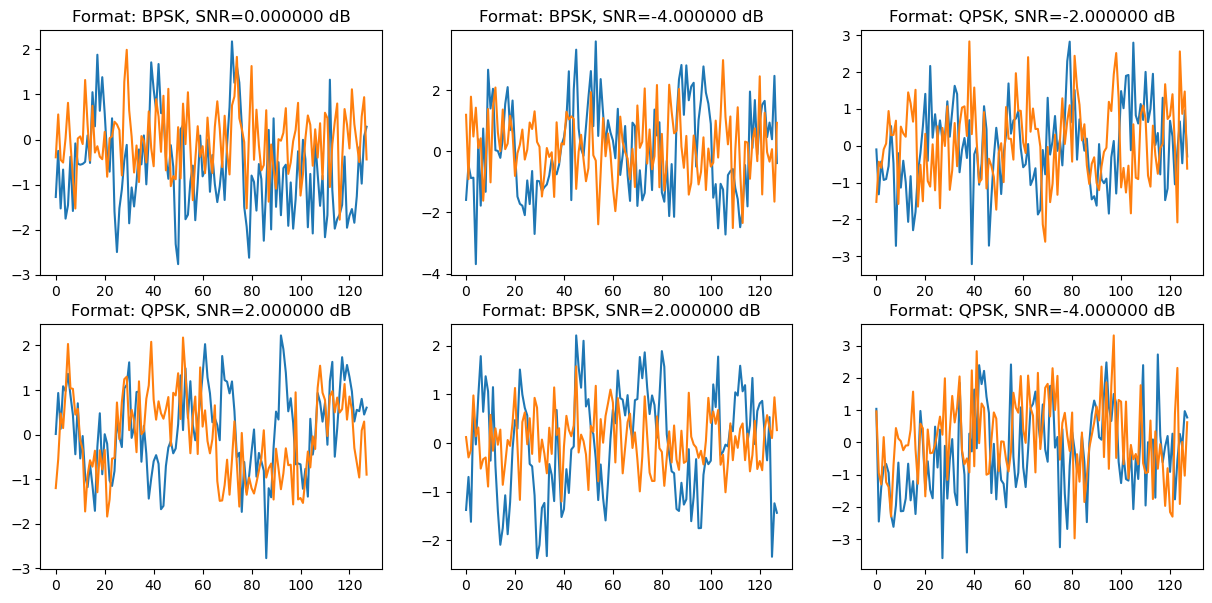

In [13]:
starti = np.random.randint(0,X_train_task_1.shape[0]-7)
plt.figure(figsize=(15,7))
for k in range(6):
    plt.subplot(2,3,k+1)
    plt.plot(np.real(X_train_task_1[k+starti,:]))
    plt.plot(np.imag(X_train_task_1[k+starti,:]))
    plt.title('Format: %s, SNR=%f dB' % (modulation_formats_task_1[y_train_task_1[k+starti]], SNR_train_task_1[k+starti]))    

In [14]:
# prepare data, convert complex data to real and imaginary parts
X_train_task_1_real = np.column_stack((np.real(X_train_task_1), np.imag(X_train_task_1)))
X_valid_task_1_real = np.column_stack((np.real(X_valid_task_1), np.imag(X_valid_task_1)))

We give a very simple classifier that is based on the fact that for BPSK, almost all the energy of a signal is contained in the inphase-component (the real part) while the imaginary part contains only noise. We compare the powers of inphase and quadrature components by calculating the ratio
$$
F = \frac{\sum_{i=1}^{128} (\mathrm{Re}\{r_i\})^2}{\sum_{i=1}^{128} (\mathrm{Im}\{r_i\})^2}
$$
We classify the signal as BPSK if $F > 1.3$, i.e., if the inphase component contains 30% more energy than the quadrature component. This factor is obtained by guessing and is in no way optimal.

The classifier is a function $y = f(\boldsymbol{x})$ with $\boldsymbol{x} = (\mathrm{Re}\{r_1\}\ \mathrm{Re}\{r_2\}\ \ldots\ \mathrm{Re}\{r_{128}\}\ \mathrm{Im}\{r_1\}\ \ldots\ \mathrm{Im}\{r_{128}\})^{\mathsf{T}}$. The output $y = 0$ in case of BPSK and $y=1$ in case of QPSK.

In [15]:
# write your own classification algorithm here
# this is the reference algoritm based on the energy contained in I and Q components
def BPSK_QPSK(data):
    # if power in I is at least x% larger than in Q, classify as BPSK
    # Question: How should x be obtained? Make x trainable and train using gradient descent?
    # Here we choose x = 1.3 (30% more power in I than in Q)
    
    energy_I = np.sum(np.square(np.real(data)), axis=1)
    energy_Q = np.sum(np.square(np.imag(data)), axis=1)
    
    classification = np.ones(data.shape[0])
    # BPSK if significantly more power in I than in Q
    classification[energy_I > 1.3*energy_Q] = 0
    return classification

In [16]:
# Validate results, show results based on validation data set
idx_SNR_valid = []
for i in range(len(SNRs_task_1)):
    idx_SNR_valid.append(np.asarray(np.where(SNR_valid_task_1 == SNRs_task_1[i])))    

error_rates_single_SNR = np.empty([len(SNRs_task_1)])
for SNR in range(len(SNRs_task_1)):
   
    # Get data coresponding to the SNR value
    X_valid_single_SNR = X_valid_task_1[idx_SNR_valid[SNR]]
    y_valid_single_SNR = y_valid_task_1[idx_SNR_valid[SNR]]


    yh = BPSK_QPSK(X_valid_single_SNR.squeeze())
    error_rates_single_SNR[SNR] = CER(yh, y_valid_single_SNR)

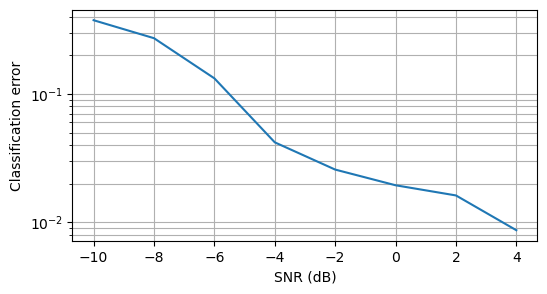

In [17]:
# Plot Results    
plt.figure(figsize=(6,3))
plt.semilogy(SNRs_task_1, error_rates_single_SNR)
plt.xlabel('SNR (dB)')
plt.ylabel('Classification error')
plt.grid(which='both')
plt.savefig('Example_result.pdf',bbox_inches='tight')

In [18]:
# Send test data through the classifier
predictions_task_1 = BPSK_QPSK(X_test_task_1.squeeze())


# Write predictions to file including sanity check
### Don't touch this part
check_predictions(X_test_task_1, predictions_task_1, range(len(modulation_formats_task_1)))

with open('Task_1_%s.pkl' % team_name,'wb') as f:
    pickle.dump(predictions_task_1,f)

type ok.
dim ok.
length ok.
Predictions are valid values.
